# IT Industry

Import libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import quandl

In [ ]:
#%pip install quandl

In [ ]:
#%pip install pmdarima

     |████████████████████████████████| 1.5 MB 4.1 MB/s 
     |████████████████████████████████| 9.5 MB 43.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [91]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
import pmdarima as pm
from pmdarima.arima import ADFTest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error as mae
#from sklearn.metrics import mean_absolute_percentage_error as mape, 
from functools import reduce
from dateutil.relativedelta import relativedelta

## Target Variable

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load PE ratio data from Capital IQ

In [ ]:
pe_df=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/KPMG summer project/ITdata/IT_PE_daily_normalized.xlsx')
pe_df=pe_df.rename(columns={'Dates': 'Date'})
pe_df=pe_df.rename(columns={'S&P 500 Information Technology (Sector) (^SP500-45) - P/Normalized EPS': 'PE'})
pe_df['Date']=pd.to_datetime(pe_df['Date'])
pe_df=pe_df.set_index('Date')
pe_df.head()

,PE
Date,
2001-08-23,59.042834
2001-08-24,63.403021
2001-08-27,63.498472
2001-08-28,61.720208
2001-08-29,60.543478


Load Price data from Capital IQ

In [ ]:
price=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/KPMG summer project/ITdata/IT_daily_price.xlsx')
price=price.rename(columns={'Dates': 'Date'})
price=price.rename(columns={'S&P 500 Information Technology (Sector) (^SP500-45) - Index Value': 'Price'})
price['Date']=pd.to_datetime(price['Date'])
price=price.set_index('Date')
price.head()

,Price
Date,
2001-08-01,383.611669
2001-08-02,391.094138
2001-08-03,386.390334
2001-08-06,379.604530
2001-08-07,377.275542


Load 10 year treasury rate from Quandl

In [ ]:
quandl.ApiConfig.api_key='91nyd8SyzTFzVtMSfKPJ'
treasury=quandl.get('FRED/DGS10')
treasury['Date']=treasury.index
treasury['Date']=pd.to_datetime(treasury['Date'])
treasury=treasury.rename(columns={'Value': 'Treasury'})
treasury=treasury.reset_index(drop=True)
treasury=treasury.set_index('Date')
treasury.head()

,Treasury
Date,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


Transformation

In [75]:
target=pe_df.join(price).join(treasury)
target
target['Year']=target.index.year
target['Month']=target.index.month
target=target.groupby([target['Year'], target['Month']]).mean()
target.head()

PE       Price  Treasury
Year Month                                  
2001 8       60.572125  339.866799  4.861429
     9       51.451013  279.650007  4.748667
     10      60.709621  300.062071  4.566818
     11      95.584733  349.391499  4.651500
     12     114.613352  365.448987  5.087500

In [76]:
target=target.reset_index()
target['Date']=pd.to_datetime(target[['Year', 'Month']].assign(DAY=1))
target=target.set_index('Date')
target.head()

,Year,Month,PE,Price,Treasury
Date,,,,,
2001-08-01,2001,8,60.572125,339.866799,4.861429
2001-09-01,2001,9,51.451013,279.650007,4.748667
2001-10-01,2001,10,60.709621,300.062071,4.566818
2001-11-01,2001,11,95.584733,349.391499,4.651500
2001-12-01,2001,12,114.613352,365.448987,5.087500


In [77]:
target['Earnings']=target['Price']/target['PE']
target['earnings_change']=target['Earnings'].pct_change()
target['Target']=target['earnings_change'] - ((1 + target['Treasury']/100)**(1/12) - 1)
target=target.dropna()
target.head()

,Year,Month,PE,Price,Treasury,Earnings,earnings_change,Target
Date,,,,,,,,
2001-09-01,2001,9,51.451013,279.650007,4.748667,5.435267,-0.031310,-0.035183
2001-10-01,2001,10,60.709621,300.062071,4.566818,4.942579,-0.090647,-0.094375
2001-11-01,2001,11,95.584733,349.391499,4.651500,3.655307,-0.260445,-0.264241
2001-12-01,2001,12,114.613352,365.448987,5.087500,3.188538,-0.127696,-0.131840
2002-01-01,2002,1,142.258870,365.618474,5.035714,2.570093,-0.193959,-0.198061


In [78]:
Target=target[['Target']]
#Target['Date']=Target.index
Target.head()

,Target
Date,
2001-09-01,-0.035183
2001-10-01,-0.094375
2001-11-01,-0.264241
2001-12-01,-0.131840
2002-01-01,-0.198061


Text(0.5, 1.0, 'Annualized EPS Growth Rate Minus 10-year Treasury Yield For IT Industry')

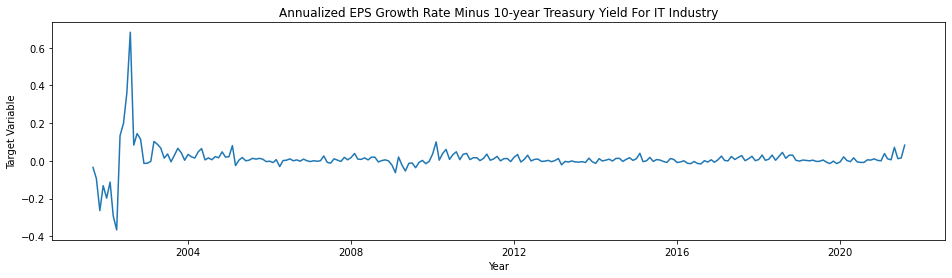

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(16,4))
plt.plot(Target['Date'],Target['Target'])
ax.set_xlabel('Year')
ax.set_ylabel('Target Variable')
ax.set_title('Annualized EPS Growth Rate Minus 10-year Treasury Yield For IT Industry')

## Independent Variables

Independent Variables Filtered

In [64]:
iv_df=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/KPMG summer project/ITdata/IT_independent_variables.xlsx')
iv_df=iv_df.rename(columns={'ds': 'Date'})
iv_df=iv_df.set_index('Date')
#iv_df['Year']=iv_df.index.year
#iv_df['Month']=iv_df.index.month
iv_df.head()

,inventory,new_orders,u_lagged9,u
Date,,,,
2001-08-01,-0.156068,-0.145102,13.551915,0.572842
2001-09-01,-0.334105,-0.443903,30.569292,0.547146
2001-10-01,-0.244538,-0.135942,0.344889,1.288541
2001-11-01,-0.220756,0.095337,-0.984319,0.482126
2001-12-01,-0.417302,0.122336,24.622835,7.357577


Market Level Prediction Result

In [ ]:
market_df1=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KPMG summer project/Final Short-term Model/updated-prediction result/one_month_prediction.csv')
market_df1['ds']=pd.to_datetime(market_df1['ds'])
market_df1=market_df1.rename(columns={'ds': 'Date'})
market_df1=market_df1.set_index('Date')
date=pd.Timestamp('2001-08-01')
market_df1=market_df1.loc[date:]
market_df1=market_df1[['yhat']]
market_df1=market_df1.rename(columns={'yhat': 'market1'})
market_df1.head()

,market1
Date,
2001-08-01,-0.350457
2001-09-01,-0.450016
2001-10-01,-0.414976
2001-11-01,-0.242129
2001-12-01,-0.608143


In [ ]:
market_df3=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KPMG summer project/Final Short-term Model/updated-prediction result/three_month_prediction.csv')
market_df3['ds']=pd.to_datetime(market_df3['ds'])
market_df3=market_df3.set_index('ds')
market_df3=market_df3.rename(columns={'ds': 'Date'})
date=pd.Timestamp('2001-08-01')
market_df3=market_df3.loc[date:]
market_df3=market_df3[['yhat']]
market_df3=market_df3.rename(columns={'yhat': 'market3'})
market_df3.head()

,market3
ds,
2001-08-01,-0.180711
2001-09-01,-0.223276
2001-10-01,-0.050709
2001-11-01,-0.468662
2001-12-01,-0.405413


In [53]:
market_df6=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KPMG summer project/Final Short-term Model/updated-prediction result/six_month_prediction.csv')
market_df6['ds']=pd.to_datetime(market_df6['ds'])
market_df6=market_df6.set_index('ds')
market_df6=market_df6.rename(columns={'ds': 'Date'})
date=pd.Timestamp('2001-08-01')
market_df6=market_df6.loc[date:]
market_df6=market_df6[['yhat']]
market_df6=market_df6.rename(columns={'yhat': 'market6'})
market_df6.head()

,market6
ds,
2001-08-01,-0.444722
2001-09-01,-0.443436
2001-10-01,-0.613667
2001-11-01,-0.180843
2001-12-01,-0.165990


In [54]:
market_df12=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KPMG summer project/Final Short-term Model/updated-prediction result/three_month_prediction.csv')
market_df12['ds']=pd.to_datetime(market_df12['ds'])
market_df12=market_df12.set_index('ds')
market_df12=market_df12.rename(columns={'ds': 'Date'})
date=pd.Timestamp('2001-08-01')
market_df12=market_df12.loc[date:]
market_df12=market_df12[['yhat']]
market_df12=market_df12.rename(columns={'yhat': 'market12'})
market_df12.head()

,market12
ds,
2001-08-01,-0.180711
2001-09-01,-0.223276
2001-10-01,-0.050709
2001-11-01,-0.468662
2001-12-01,-0.405413


In [55]:
market_df18=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KPMG summer project/Final Short-term Model/updated-prediction result/three_month_prediction.csv')
market_df18['ds']=pd.to_datetime(market_df18['ds'])
market_df18=market_df18.set_index('ds')
market_df18=market_df18.rename(columns={'ds': 'Date'})
date=pd.Timestamp('2001-08-01')
market_df18=market_df18.loc[date:]
market_df18=market_df18[['yhat']]
market_df18=market_df18.rename(columns={'yhat': 'market18'})
market_df18.head()

,market18
ds,
2001-08-01,-0.180711
2001-09-01,-0.223276
2001-10-01,-0.050709
2001-11-01,-0.468662
2001-12-01,-0.405413


In [56]:
market_df=market_df1.join(market_df3).join(market_df6).join(market_df12).join(market_df18)
market_df.head()

,market1,market3,market6,market12,market18
Date,,,,,
2001-08-01,-0.350457,-0.180711,-0.444722,-0.180711,-0.180711
2001-09-01,-0.450016,-0.223276,-0.443436,-0.223276,-0.223276
2001-10-01,-0.414976,-0.050709,-0.613667,-0.050709,-0.050709
2001-11-01,-0.242129,-0.468662,-0.180843,-0.468662,-0.468662
2001-12-01,-0.608143,-0.405413,-0.165990,-0.405413,-0.405413


In [66]:
iv_df=iv_df.join(market_df)
iv_df.head()

,inventory,new_orders,u_lagged9,u,market1,market3,market6,market12,market18
Date,,,,,,,,,
2001-08-01,-0.156068,-0.145102,13.551915,0.572842,-0.350457,-0.180711,-0.444722,-0.180711,-0.180711
2001-09-01,-0.334105,-0.443903,30.569292,0.547146,-0.450016,-0.223276,-0.443436,-0.223276,-0.223276
2001-10-01,-0.244538,-0.135942,0.344889,1.288541,-0.414976,-0.050709,-0.613667,-0.050709,-0.050709
2001-11-01,-0.220756,0.095337,-0.984319,0.482126,-0.242129,-0.468662,-0.180843,-0.468662,-0.468662
2001-12-01,-0.417302,0.122336,24.622835,7.357577,-0.608143,-0.405413,-0.165990,-0.405413,-0.405413


In [60]:
'''def add_lags(var_names, lag_periods):
    for var in var_names:
        for lag in lag_periods:
            var_col=var + '_' + str(lag)
            iv_df[var_col]=iv_df[var].shift(lag)

ex_columns=['u']
lag_periods=list(range(1,14))
add_lags(ex_columns, lag_periods)'''

In [67]:
iv_df.head()

,inventory,new_orders,u_lagged9,u,market1,market3,market6,market12,market18
Date,,,,,,,,,
2001-08-01,-0.156068,-0.145102,13.551915,0.572842,-0.350457,-0.180711,-0.444722,-0.180711,-0.180711
2001-09-01,-0.334105,-0.443903,30.569292,0.547146,-0.450016,-0.223276,-0.443436,-0.223276,-0.223276
2001-10-01,-0.244538,-0.135942,0.344889,1.288541,-0.414976,-0.050709,-0.613667,-0.050709,-0.050709
2001-11-01,-0.220756,0.095337,-0.984319,0.482126,-0.242129,-0.468662,-0.180843,-0.468662,-0.468662
2001-12-01,-0.417302,0.122336,24.622835,7.357577,-0.608143,-0.405413,-0.165990,-0.405413,-0.405413


# Aggregate Data

In [79]:
df=Target.join(iv_df)
df.head()

,Target,inventory,new_orders,u_lagged9,u,market1,market3,market6,market12,market18
Date,,,,,,,,,,
2001-09-01,-0.035183,-0.334105,-0.443903,30.569292,0.547146,-0.450016,-0.223276,-0.443436,-0.223276,-0.223276
2001-10-01,-0.094375,-0.244538,-0.135942,0.344889,1.288541,-0.414976,-0.050709,-0.613667,-0.050709,-0.050709
2001-11-01,-0.264241,-0.220756,0.095337,-0.984319,0.482126,-0.242129,-0.468662,-0.180843,-0.468662,-0.468662
2001-12-01,-0.131840,-0.417302,0.122336,24.622835,7.357577,-0.608143,-0.405413,-0.165990,-0.405413,-0.405413
2002-01-01,-0.198061,0.030870,-0.755937,-0.273865,-0.391417,-0.612288,-0.290757,-0.090202,-0.290757,-0.290757


In [80]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/KPMG summer project/ITdata/updated_IT_data.csv')

Check seasonality

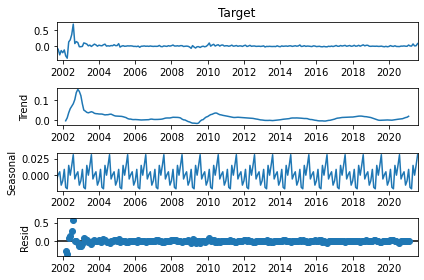

In [71]:
decomp_results=seasonal_decompose(df['Target'], period=12)
decomp_results.plot()
plt.show()

Shift target variable by 1, 3, 6, 12, 18 months

In [81]:
df_1=df
df_1=df_1.reset_index()
df_1['Target']=df_1['Target'].shift(-1)
df_1['Date']=df_1['Date'].shift(-1)
df_1=df_1.dropna()
df_1=df_1.set_index('Date')
df_1['Month']=df_1.index.month
df_1

,Target,inventory,new_orders,u_lagged9,u,market1,market3,market6,market12,market18,Month
Date,,,,,,,,,,,
2001-10-01,-0.094375,-0.334105,-0.443903,3.056929e+01,0.547146,-0.450016,-0.223276,-0.443436,-0.223276,-0.223276,10
2001-11-01,-0.264241,-0.244538,-0.135942,3.448888e-01,1.288541,-0.414976,-0.050709,-0.613667,-0.050709,-0.050709,11
2001-12-01,-0.131840,-0.220756,0.095337,-9.843191e-01,0.482126,-0.242129,-0.468662,-0.180843,-0.468662,-0.468662,12
2002-01-01,-0.198061,-0.417302,0.122336,2.462284e+01,7.357577,-0.608143,-0.405413,-0.165990,-0.405413,-0.405413,1
2002-02-01,-0.112940,0.030870,-0.755937,-2.738647e-01,-0.391417,-0.612288,-0.290757,-0.090202,-0.290757,-0.290757,2
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-01,0.002434,0.025257,0.011983,3.354579e+00,62.772039,0.009809,0.027331,0.227182,0.027331,0.027331,12
2021-01-01,-0.000057,0.045347,0.191630,-9.878776e-01,-0.948903,-0.000538,0.016424,0.183293,0.016424,0.016424,1
2021-02-01,0.038510,0.028788,0.275006,2.712952e+09,4.709801,-0.000172,0.004035,0.089681,0.004035,0.004035,2


In [82]:
df_3=df
df_3=df_3.reset_index()
df_3['Target']=df_3['Target'].shift(-3)
df_3['Date']=df_3['Date'].shift(-3)
df_3=df_3.dropna()
df_3=df_3.set_index('Date')
df_3['Month']=df_3.index.month
df_3

,Target,inventory,new_orders,u_lagged9,u,market1,market3,market6,market12,market18,Month
Date,,,,,,,,,,,
2001-12-01,-0.131840,-0.334105,-0.443903,3.056929e+01,0.547146,-0.450016,-0.223276,-0.443436,-0.223276,-0.223276,12
2002-01-01,-0.198061,-0.244538,-0.135942,3.448888e-01,1.288541,-0.414976,-0.050709,-0.613667,-0.050709,-0.050709,1
2002-02-01,-0.112940,-0.220756,0.095337,-9.843191e-01,0.482126,-0.242129,-0.468662,-0.180843,-0.468662,-0.468662,2
2002-03-01,-0.292307,-0.417302,0.122336,2.462284e+01,7.357577,-0.608143,-0.405413,-0.165990,-0.405413,-0.405413,3
2002-04-01,-0.366633,0.030870,-0.755937,-2.738647e-01,-0.391417,-0.612288,-0.290757,-0.090202,-0.290757,-0.290757,4
...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01,0.038510,0.025257,0.011983,3.354579e+00,62.772039,0.009809,0.027331,0.227182,0.027331,0.027331,2
2021-03-01,0.010599,0.045347,0.191630,-9.878776e-01,-0.948903,-0.000538,0.016424,0.183293,0.016424,0.016424,3
2021-04-01,0.005362,0.028788,0.275006,2.712952e+09,4.709801,-0.000172,0.004035,0.089681,0.004035,0.004035,4


In [83]:
df_6=df
df_6=df_6.reset_index()
df_6['Target']=df_6['Target'].shift(-6)
df_6['Date']=df_6['Date'].shift(-6)
df_6=df_6.dropna()
df_6=df_6.set_index('Date')
df_6['Month']=df_6.index.month
df_6

,Target,inventory,new_orders,u_lagged9,u,market1,market3,market6,market12,market18,Month
Date,,,,,,,,,,,
2002-03-01,-0.292307,-0.334105,-0.443903,3.056929e+01,0.547146,-0.450016,-0.223276,-0.443436,-0.223276,-0.223276,3
2002-04-01,-0.366633,-0.244538,-0.135942,3.448888e-01,1.288541,-0.414976,-0.050709,-0.613667,-0.050709,-0.050709,4
2002-05-01,0.133001,-0.220756,0.095337,-9.843191e-01,0.482126,-0.242129,-0.468662,-0.180843,-0.468662,-0.468662,5
2002-06-01,0.199389,-0.417302,0.122336,2.462284e+01,7.357577,-0.608143,-0.405413,-0.165990,-0.405413,-0.405413,6
2002-07-01,0.359578,0.030870,-0.755937,-2.738647e-01,-0.391417,-0.612288,-0.290757,-0.090202,-0.290757,-0.290757,7
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-01,0.005362,-0.002103,0.331009,8.901268e+00,-0.991146,0.013084,0.160532,-0.113598,0.160532,0.160532,4
2021-05-01,0.071299,0.025257,0.011983,3.354579e+00,62.772039,0.009809,0.027331,0.227182,0.027331,0.027331,5
2021-06-01,0.011507,0.045347,0.191630,-9.878776e-01,-0.948903,-0.000538,0.016424,0.183293,0.016424,0.016424,6


In [84]:
df_12=df
df_12=df_12.reset_index()
df_12['Target']=df_12['Target'].shift(-12)
df_12['Date']=df_12['Date'].shift(-12)
df_12=df_12.dropna()
df_12=df_12.set_index('Date')
df_12['Month']=df_12.index.month
df_12

,Target,inventory,new_orders,u_lagged9,u,market1,market3,market6,market12,market18,Month
Date,,,,,,,,,,,
2002-09-01,0.083570,-0.334105,-0.443903,30.569292,5.471457e-01,-0.450016,-0.223276,-0.443436,-0.223276,-0.223276,9
2002-10-01,0.144311,-0.244538,-0.135942,0.344889,1.288541e+00,-0.414976,-0.050709,-0.613667,-0.050709,-0.050709,10
2002-11-01,0.114729,-0.220756,0.095337,-0.984319,4.821265e-01,-0.242129,-0.468662,-0.180843,-0.468662,-0.468662,11
2002-12-01,-0.013632,-0.417302,0.122336,24.622835,7.357577e+00,-0.608143,-0.405413,-0.165990,-0.405413,-0.405413,12
2003-01-01,-0.013019,0.030870,-0.755937,-0.273865,-3.914174e-01,-0.612288,-0.290757,-0.090202,-0.290757,-0.290757,1
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-01,0.005362,0.112379,0.015607,81.491674,2.712952e+09,-0.392623,0.023016,0.116711,0.023016,0.023016,4
2021-05-01,0.071299,0.015471,-0.050555,8.384238,-1.037983e-01,-0.453452,0.085725,0.119794,0.085725,0.085725,5
2021-06-01,0.011507,0.019118,0.024387,-0.546833,2.169983e+00,0.368348,-0.059290,0.145287,-0.059290,-0.059290,6


In [85]:
df_18=df
df_18=df_18.reset_index()
df_18['Target']=df_18['Target'].shift(-18)
df_18['Date']=df_18['Date'].shift(-18)
df_18=df_18.dropna()
df_18=df_18.set_index('Date')
df_18['Month']=df_18.index.month
df_18

,Target,inventory,new_orders,u_lagged9,u,market1,market3,market6,market12,market18,Month
Date,,,,,,,,,,,
2003-03-01,0.102729,-0.334105,-0.443903,30.569292,0.547146,-0.450016,-0.223276,-0.443436,-0.223276,-0.223276,3
2003-04-01,0.087681,-0.244538,-0.135942,0.344889,1.288541,-0.414976,-0.050709,-0.613667,-0.050709,-0.050709,4
2003-05-01,0.067519,-0.220756,0.095337,-0.984319,0.482126,-0.242129,-0.468662,-0.180843,-0.468662,-0.468662,5
2003-06-01,0.014086,-0.417302,0.122336,24.622835,7.357577,-0.608143,-0.405413,-0.165990,-0.405413,-0.405413,6
2003-07-01,0.036401,0.030870,-0.755937,-0.273865,-0.391417,-0.612288,-0.290757,-0.090202,-0.290757,-0.290757,7
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-01,0.005362,0.021674,-0.075751,8.384238,-0.968324,0.013827,-0.007308,0.123134,-0.007308,-0.007308,4
2021-05-01,0.071299,0.026640,-0.095673,-0.805808,-0.999831,0.008040,-0.019553,0.097071,-0.019553,-0.019553,5
2021-06-01,0.011507,0.079400,0.122672,-0.256444,6.863274,0.024932,0.008484,0.095254,0.008484,0.008484,6


# Model

## SARIMAX Model 1 month horizon

In [93]:
model_exvar=['inventory','new_orders','u_lagged9', 'market1']

split_date=pd.Timestamp('2017-01-01')

train=df_1.loc[:split_date]
y_train=train['Target']
X_train=train[model_exvar]

test=df_1.loc[(split_date + relativedelta(months = 1)):]
y_test=test['Target']
X_test=test[model_exvar]

Find the best p & q, using aic as criteria

In [94]:
results=pm.auto_arima(y_train, seasonal=True, m=12, D=1, information_criterion='aic', exogenous=X_train)
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  184
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                 218.151
Date:                              Mon, 30 Aug 2021   AIC                           -420.301
Time:                                      16:27:07   BIC                           -395.121
Sample:                                  10-01-2001   HQIC                          -410.085
                                       - 01-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
inventory      0.0579      0.048      1.205      0.228      -0.036       0.152
new_orders     0.00

In [ ]:
# Another way to do it
'''model=pm.auto_arima(y=y_train, X=X_train, 
                      start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5, m=12,
                      start_P=0, seasonal=True,
                      d=None, D=1, trace=True,
                      error_action='ignore',
                      suppress_warnings=True
                     )
print(model.summary())'''

In [89]:
sarimax_model=SARIMAX(y_train, 
                order=(1,0,0), 
                seasonal_order=(1,1,[1],12)
                , exog=X_train
                )

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


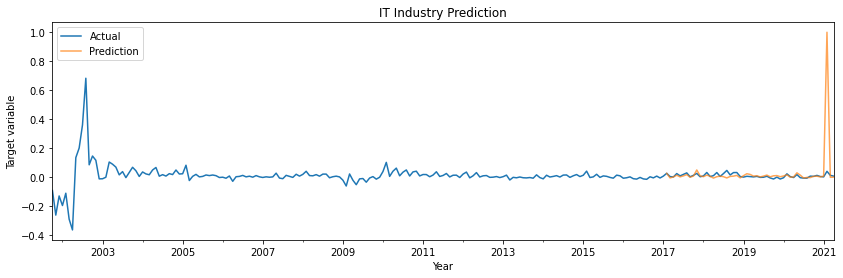

MAE: 0.029


In [106]:
sarimax_mod_fit=sarimax_model.fit()

sarimax_pred=sarimax_mod_fit.get_prediction(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

sar_pred=sarimax_pred.predicted_mean
sar_pred[sar_pred>1]=1

sar_pred_ci=sarimax_pred.conf_int()

ax=df_1['Target'].plot(label='Actual')
sar_pred.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Year')
ax.set_ylabel('Target variable')
plt.title('IT Industry Prediction')
plt.legend()
plt.show()

#print('MAPE:', round(mape(y_test, sar_pred), 3))
print('MAE:', round(mae(y_test, sar_pred), 3))

Performance Matrix

In [107]:
def forecast_accuracy(forecast, actual):
    '''
    These are some accuracy metrics we use to compare how accurate our forecast values are.
    '''
    
    mape=np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me=np.mean(forecast - actual)             # ME
    mae=np.mean(np.abs(forecast - actual))    # MAE
    mpe=np.mean((forecast - actual)/actual)   # MPE
    rmse=np.mean((forecast - actual)**2)**.5  # RMSE
    corr=np.corrcoef(forecast, actual)[0,1]   # corr
    mins=np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs=np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax=1 - np.mean(mins/maxs)             # minmax                
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

In [108]:
metrics=forecast_accuracy(sar_pred,y_test)
print('MAPE: %0.5f' % metrics['mape'])
print('MAE: %0.5f' % metrics['mae'])

MAPE: 4.61612
MAE: 0.02933


### Pink Plot

In [ ]:
sar1_pred=sarimax_pred.predicted_mean
sar1_pred_ci=sarimax_pred.conf_int()

pred_results1=pd.DataFrame(df_1['final_EPS_growth']).join(sar1_pred).join(sar1_pred_ci)
pred_results1

,final_EPS_growth,predicted_mean,lower final_EPS_growth,upper final_EPS_growth
DATE,,,,
2001-11-30,-1.024130,NaN,NaN,NaN
2001-12-31,-0.856306,NaN,NaN,NaN
2002-01-31,-0.973888,NaN,NaN,NaN
2002-02-28,-0.802243,NaN,NaN,NaN
2002-03-31,-1.035129,NaN,NaN,NaN
...,...,...,...,...
2020-11-30,0.043581,0.062889,-2.850137,2.975915
2020-12-31,0.115149,-0.004025,-2.917051,2.909001
2021-01-31,-0.002475,0.033857,-2.911617,2.979331


In [ ]:
# import os
import re
import datetime
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

def plot_forecast(y='y', yhat='yhat', 
                  ci_lower=None, ci_upper=None, 
                   
                  data=None, data_path=None, data_index_col=None, 
                  data_drop_duplicates=True, keep='last',
                   
                  start_date=None, end_date=None, 
                  date_format='%Y-%m-%d',
                   
                   plot_style='classic', 
                   plot_size=(20,12), plot_titlesize=18,
                   
                   y_color='k', y_ls='-', y_lw=1.5, 
                   y_marker='None', y_markersize=8, y_facecolor='k',
                   
                   yhat_color='#CC1D92', yhat_ls='--', yhat_lw=3,
                   yhat_marker='None', yhat_markersize=8, yhat_facecolor='#CC1D92',
                   
                   vline_color='k', vline_ls='-', vline_lw=2,
                   
                   ci_label='_nolegend_', ci_color='#FA71CD',
                   
                   print_mse=True):
    
    '''
    A basic function to plot observed, predicted values. 
    ## Use is intended for team members. Client(s) should be interacting with interactive plots. ##
    ## Exception,errors are not handled well here ## 
    
    Parameters
    ----------
    y: str, default='y'
        Column name of observed values.
        
    yhat: str, default='yhat'
        Column name of predicted values.
        
    ci_lower: str, optional
        Column name of upper confidence interval.
        
    ci_upper: str, optional
        Column name of lower confidence interval.
    
    data: pd.DataFrame, optional
        DataFrame with dates and observed, predicted values.
        
    data_path: str, optional
        Path to load .csv file as pd.DataFrame.
        
    data_index_col: int, str, optional
        Column index or name to set as index.
        
    data_drop_duplicates: bool, default=True
        If True, drop duplicate index values.
    
    keep: str, default='last'
        Which entry to keep when dropping duplicates. # --> pd.DataFrame.drop_duplicates(keep='')
    
    start_date: str, optional
        Start date to subset data and plot (by default, expects '%Y-%m-%d').
        
    end_date: str, optional
        End date to subset data and plot (by default, expects '%Y-%m-%d').
        
    date_format: str, default='%Y-%m-%d'
        Format to convert start_date, end_date to datetime.
    
    plot_style: matplotlib style sheet, default='classic'
        Matplotlib plotting style to use.
        
    plot_size: tuple, default=(20,12)
        Size of figure output. Does not refer to size of individual plots.

    plot_titlesize: int, default=18
        Title size of plots. Also, affects label, tick size --> (label size=plot_titlesize - 6).
    
    print_mse: bool, default=True
        If True, print mse, rmse.
        
    ci_label: str, default='_nolegend_'
        Confidence interval label to show in legend.
        (e.g., ci_label='95%' shows '95% Confidence Interval' in legend)
        
    Line, marker style parameters
    -----------------------------
    ci_color: str, default='#FA71CD'
        Fill color.
    
    for x in [y, yhat, vline]:
    
        x_color: str
            Line color.
    
        x_marker: str, default='None'
            Type of marker.

        x_ls: str
            Linestyle.

        x_lw: int
            Linewidth.

        x_markersize: int
            Markersize.
            
        x_facecolor: str
            Marker face color.

    Return
    ------
    fig: matplotlib figure
    
    '''
    
    # - - - - - - - - - - - - - - - Add - -  - - - - - - - - - - - - #
    # ''data' or 'data_path' is required.'
    # if both provided, use 'data'
    # - - - - - - - - - - - - - - - Add - -  - - - - - - - - - - - - #
    
    # Try loading df from pathname, if data is not provided. 
    if data is None:
        try: 
            df=pd.read_csv(data_path, parse_dates=True, index_col=data_index_col)

        # Need to improve how exceptions/errors are handled
        except Exception as e: 
            df=pd.read_csv(data_path)
            print_basic_exception(e); print('\n\nFirst 3 rows shown below.')
            return df.head(3)

    # If df provided, try to set index if not already datetime
    else:
        # Make copy bc below uses 'inplace=True' and want to avoid modifying 'data'
        df=data.copy()
        
        # This part needs to be better.. e.g. except: //
        if type(df.index) !=pd.DatetimeIndex and df.index.dtype !='O': #  type(df.index) !=str:
            
            # Below needs to be changed..
            try: df.set_index(data_index_col, inplace=True)
            except: df.set_index(df.columns[data_index_col], inplace=True)
                
            df.index=pd.to_datetime(df.index)
            
        else:
            first_idx=df.index[0]
            df.index=pd.to_datetime(df.index)
            print('* Index converted to datetime. Please verify example below.\nfrom {} to {}\n'\
                  .format(first_idx, df.index[0]))
            
    ## Drop duplicates
    if data_drop_duplicates:
    # if len(set(df.index)) !=len(df.index):
        df=df.loc[~df.index.duplicated(keep=keep)]
        print('* Dropping duplicate index values. Keeping {}.\n'.format(keep))
    
    # - - - - - - - - - - - - - - - DEL - - - - - - - - - - - - - - - - - - - - - - - - - //
    # Fuzzy match col names to set y,yhat,ci without specifying in params
    # if dumb_y:
        
        ## Below may be better as param later..
        # try:
        # simple_match={}
        
        # A dumb message to indicate this is not a very good way to do it..
        # dumb_msg='Moo!!!! * This overrides 'y', 'yhat', 'ci_lower', 'ci_upper'\n'
        # print(dumb_msg)
        
        # Select closest match...
        # y_cand=
        # yhat_cand=
        # ci_lower_cand=
        # ci_upper_cand=
        # except:
        # try again~
    # else: 
    # - - - - - - - - - - - - - - - DEL - - - - - - - - - - - - - - - - - - - - - - - - -
    
    # Create plots
    fig=plt.figure(figsize=plot_size)

    gs=gridspec.GridSpec(3, 2, height_ratios=[3, 4, 3])
    
    # First plot
    ax1=fig.add_subplot(gs[0, :])
    
    # Second plot
    ax2=fig.add_subplot(gs[1, :])
    
    # Lower left
    ax3=fig.add_subplot(gs[2, 0])
    
    # Lower right
    ax4=fig.add_subplot(gs[2, 1])
    
    # Plot forecasts without setting style
    with plt.style.context(plot_style):
        
        # if not specified start date is 5 years prior
        if start_date is None: start_date=df.index[-1] - pd.DateOffset(months=60)
        
        ## Subset dataframe based on date <--- this should be changed to be based on k_months
        subset_df=df.pipe(process_date, start_date, end_date, date_format) # process_date(df, )
        
        # Prep to plot in a forloop
        df_all=[df, subset_df]
        top_two_plots=[ax1, ax2]       
        
        for dataframe, axplot in zip(df_all, top_two_plots):
            
            # Plot observed
            dataframe[y].plot(ax=axplot, label='Observed', c=y_color, lw=y_lw,
                             marker=y_marker, markersize=y_markersize, ls=y_ls, 
                              markerfacecolor=y_facecolor)
            
            # Plot predicted
            dataframe[yhat].plot(ax=axplot, label='Predicted', lw=yhat_lw, c=yhat_color,
                                marker=yhat_marker, markersize=yhat_markersize, 
                                 markerfacecolor=yhat_facecolor, ls=yhat_ls)
            
            ## Plot confidence interval
            # if ci_lower and ci_upper is not None:
            try:
                axplot.fill_between(x=dataframe.index, y1=dataframe[ci_lower], y2=dataframe[ci_upper],
                                    alpha=0.2, color=ci_color, label='{} Conf. Interval'.format(ci_label))
            except Exception as e:
                print_basic_exception(e) # <---- need something here
            
            # Plot horizontal line at y=0
            axplot.axhline(y=0, c='gray', alpha=1, ls=':', lw=2)
            
            # Set labels, titles
            axplot.set_ylabel('Annualized rate', size=plot_titlesize-6)
            axplot.set_title('Model Fit/Forecast from {} to {}'\
                             .format(dataframe.index[0].strftime('%B %Y'), dataframe.index[-1].strftime('%B %Y')),
                             size=plot_titlesize)
            
        
        
        ## Plot horizontal line in top two plots if observed contains null
        ## Assuming only null in 'y' is bc no data avail at date. If df has null otherwise, problem.
        ## Is sep. loop bc of axplot.get_ylim()
        for dataframe, axplot in zip(df_all, top_two_plots):
            
            # Check if observed contains null vals
            if dataframe[y].isna().sum() > 0:
                
                # Get last date
                y_end=dataframe[y].dropna().index[-1]
                print(y_end)
                ax_ylim=axplot.get_ylim()[1]

                # If observed end is before end of forecast end
                if y_end < dataframe.index[-1]:
                    # Plot vertical line
                    axplot.axvline(y_end, c=vline_color, ls=vline_ls, lw=vline_lw)
                    # Plot date as text
                    axplot.text(x=y_end, y=ax_ylim * 0.9, s=y_end.strftime('%b %d, %Y'), 
                                ha='right', va='center', size=plot_titlesize-6)
        
        # Calc. residual (not standardized)
        resid=(df[y] - df[yhat]).dropna() 
        
        # Plot residuals in lower left plot
        resid.plot(ax=ax3, ls=':', lw=1, marker='o', alpha=0.75)
        
        # Plot line at y=0
        ax3.axhline(y=0, c='k', ls='--', lw=2, alpha=0.75)
        
        # Set lower left title
        ax3.set_title('Residuals', size=plot_titlesize)
        
        # Plot autocorr in lower right plot
        plot_acf(resid, ax=ax4)
        
        # Set lower right title, x-label
        ax4.set_title('Autocorrelation of Residuals', size=plot_titlesize)
        ax4.set_xlabel('Lag', size=plot_titlesize-6)
        
        # Set xticks, labels in loop <--- this part can be better!! mybad--short on time..
        for f_ax in [ax1, ax2, ax3, ax4]:
            f_ax.tick_params(axis='both', rotation=0, labelsize=plot_titlesize-6)
            f_ax.grid('both', ls=':')
            
        for f_ax in [ax1, ax2, ax3]:
            f_ax.set_xlabel('Date', size=plot_titlesize-6)
        
        for f_ax in [ax1, ax2]:
            f_ax.legend(loc='best')
        
        # Print mse, rmse
        if print_mse:
            mse=np.mean(np.square(resid))
            rmse=np.sqrt(mse)
            
            print('- from {} to {} -'.format(resid.index[0].strftime('%B %d, %Y'),
                                             resid.index[-1].strftime('%B %d, %Y')))
            
            print('mse: {:.4f}\nrmse: {:.4f}'.format(mse, rmse))
        
        plt.tight_layout()
        plt.show()
        return fig
    
    
def process_date(df, start_date=None, end_date=None, date_format='%Y-%m-%d'):
    '''Return subset based on start, end date'''
    
    if start_date is not None:
        start_datetime=pd.to_datetime(start_date, format=date_format)
        subset=df[(df.index >=start_datetime)] ## sample.truncate(after=)
        
    if end_date is not None:
        end_datetime=pd.to_datetime(end_date, format=date_format)
        subset=df[(df.index < end_datetime)]
    
    return subset
    # try: // except: # Exception as e:
    
# Below is not very good way of doing this...
def print_basic_exception(e, traceback=False):
    if traceback: raise e
    else: print('* Oops. Something went wrong ---> {}'.format(e))

* Index converted to datetime. Please verify example below.
from 2001-11-30 00:00:00 to 2001-11-30 00:00:00

* Dropping duplicate index values. Keeping last.

* Oops. Something went wrong ---> None
* Oops. Something went wrong ---> None


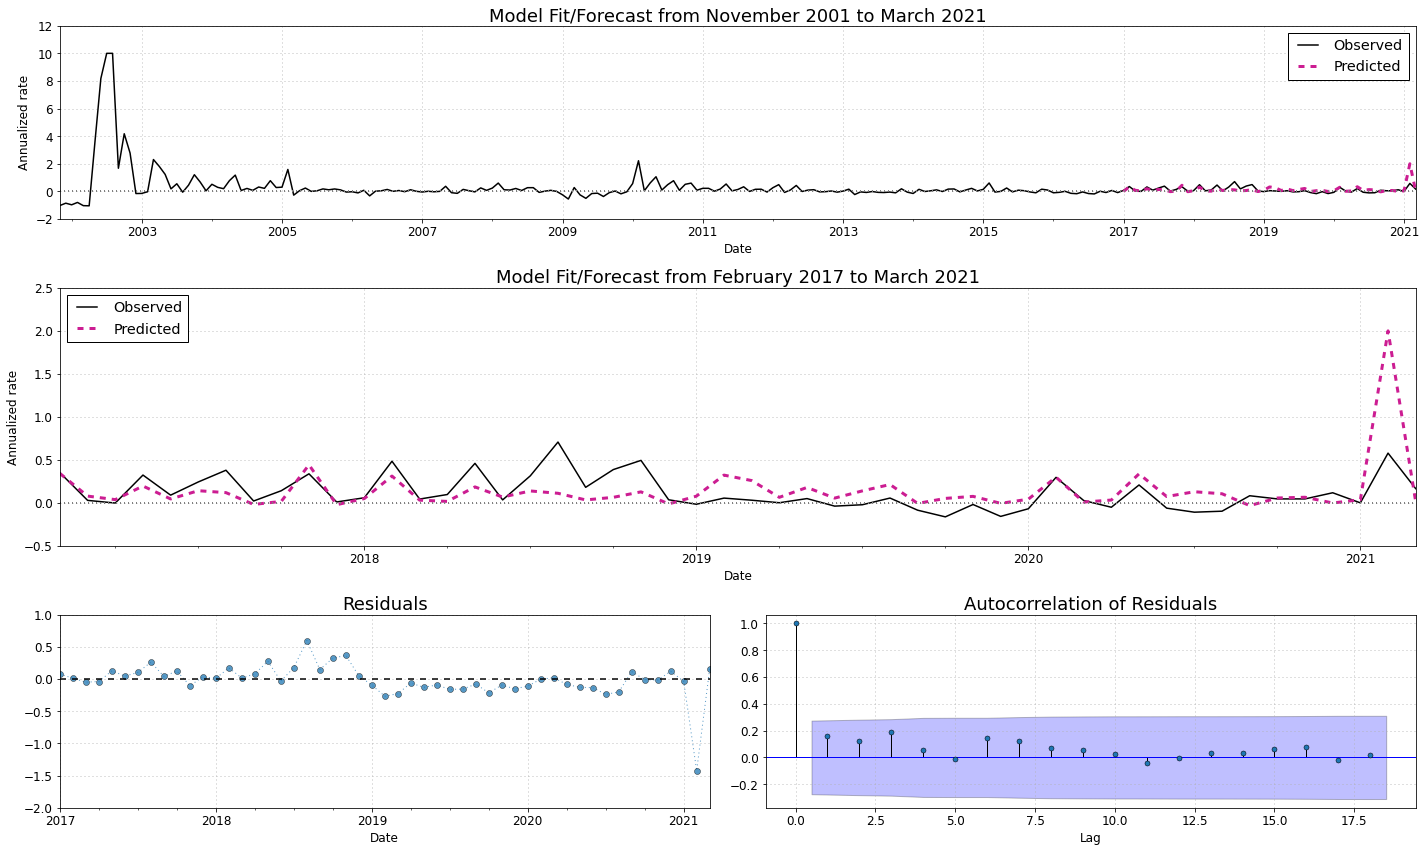

In [ ]:
f=plot_forecast(data=pred_results1, data_index_col=0, # <-- col to set as index / can also be 'ds' or wtvr
                  y='final_EPS_growth', yhat='predicted_mean', 
                  #ci_lower='lower target', ci_upper='upper target',
                  start_date='2017-02-01',
                  print_mse=False)

SARIMA

## SARIMAX Model 3 Month Horizon

In [109]:
model_exvar=['inventory','new_orders','u_lagged9', 'market3']

split_date=pd.Timestamp('2017-01-01')

train=df_3.loc[:split_date]
y_train=train['Target']
X_train=train[model_exvar]

test=df_3.loc[(split_date + relativedelta(months = 1)):]
y_test=test['Target']
X_test=test[model_exvar]

Find the best p & q, using aic as criteria

In [110]:
results=pm.auto_arima(y_train, seasonal=True, m=12, D=1, information_criterion='aic', exogenous=X_train)
print(results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  182
Model:             SARIMAX(1, 0, 0)x(0, 1, [1, 2], 12)   Log Likelihood                 217.992
Date:                                 Mon, 30 Aug 2021   AIC                           -419.983
Time:                                         16:40:25   BIC                           -394.897
Sample:                                     12-01-2001   HQIC                          -409.803
                                          - 01-01-2017                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
inventory     -0.0331      0.036     -0.923      0.356      -0.103       0

In [111]:
sarimax_model=SARIMAX(y_train, 
                order=(1,0,0), 
                seasonal_order=(0,1,[1, 2],12)
                , exog=X_train
                )

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


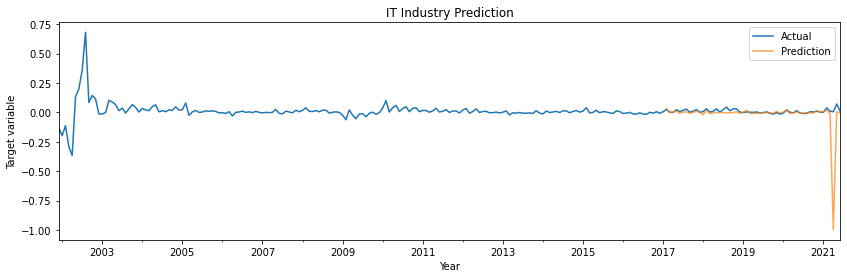

MAE: 0.032


In [115]:
sarimax_mod_fit=sarimax_model.fit()

sarimax_pred=sarimax_mod_fit.get_prediction(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

sar_pred=sarimax_pred.predicted_mean
sar_pred[sar_pred<-1]=-1

sar_pred_ci=sarimax_pred.conf_int()

ax=df_3['Target'].plot(label='Actual')
sar_pred.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Year')
ax.set_ylabel('Target variable')
plt.title('IT Industry Prediction')
plt.legend()
plt.show()

#print('MAPE:', round(mape(y_test, sar_pred), 3))
print('MAE:', round(mae(y_test, sar_pred), 3))

Performance Matrix

In [116]:
metrics=forecast_accuracy(sar_pred,y_test)
print('MAPE: %0.5f' % metrics['mape'])
print('MAE: %0.5f' % metrics['mae'])

MAPE: 8.24977
MAE: 0.03153
